# **Messi outlier**
## Goal contributions per match

The aim of this notebook is to assess whether Messi’s goal contribution per match can be considered an outlier when compared to other top football players.
*Goal contribution per match* is the total goals + assists divided by total matches played by a player.

### Datasets
We use `dataset2_player_performances.parquet` & `dataset2_player_profiles`

- `dataset2_player_performances.parquet`: provides football player performances
- `dataset2_player_profiles`: provides football player names and other personal attributes

We merge the performance and profiles dataset using player_id as link

**Resulting dataset: `merged_player_data.parquet`**

In [1]:
import pandas as pd

# Load datasets (go up one level from notebooks/ to reach data/)
df_perf = pd.read_parquet("../data/dataset2_player_performances.parquet")
df_profiles = pd.read_parquet("../data/dataset2_player_profiles.parquet")

# Merge on player_id
df_merged = df_perf.merge(df_profiles, on="player_id", how="left")

# Save the merged dataset back into data/ or notebooks/
df_merged.to_parquet("../data/merged_player_data.parquet", index=False)

### We now focus on `assists`, `goals`, and `matches` variables to build `GoalContribution`

In [5]:
import pandas as pd

# Load merged dataset
df_merged = pd.read_parquet("../data/merged_player_data.parquet")

# Show all available column names
print(df_merged.columns.tolist())

# (Optional) peek at the first rows to see the structure
print(df_merged.head())


['player_id', 'season_name', 'competition_id', 'competition_name', 'team_id', 'team_name', 'nb_in_group', 'nb_on_pitch', 'goals', 'assists', 'own_goals', 'subed_in', 'subed_out', 'yellow_cards', 'second_yellow_cards', 'direct_red_cards', 'penalty_goals', 'minutes_played', 'goals_conceded', 'clean_sheets', 'player_slug', 'player_name', 'player_image_url', 'name_in_home_country', 'date_of_birth', 'place_of_birth', 'country_of_birth', 'height', 'citizenship', 'is_eu', 'position', 'main_position', 'foot', 'current_club_id', 'current_club_name', 'joined', 'contract_expires', 'outfitter', 'social_media_url', 'player_agent_id', 'player_agent_name', 'contract_option', 'date_of_last_contract_extension', 'on_loan_from_club_id', 'on_loan_from_club_name', 'contract_there_expires', 'second_club_url', 'second_club_name', 'third_club_url', 'third_club_name', 'fourth_club_url', 'fourth_club_name', 'date_of_death']
   player_id season_name competition_id   competition_name  team_id  \
0          1     

In [7]:
import pandas as pd

# Load merged dataset
df_merged = pd.read_parquet("../data/merged_player_data.parquet")

# Filter Lionel Messi by player_id
messi_data = df_merged[df_merged["player_id"] == 28003]

# Show per-season stats
print(messi_data[["season_name", "competition_name", "team_name", 
                  "nb_on_pitch", "minutes_played", "goals", "assists"]])

# Aggregate totals
messi_totals = (
    messi_data.agg({
        "nb_on_pitch": "sum",
        "minutes_played": "sum",
        "goals": "sum",
        "assists": "sum"
    })
)

print("\nMessi totals (career in dataset):")
print(messi_totals)

       season_name  competition_name       team_name  nb_on_pitch  \
666791        2025       Leagues Cup  Inter Miami CF            4   
666792        2025               MLS  Inter Miami CF           19   
666793        2025    Club World Cup  Inter Miami CF            4   
666794       24/25       CONCACAF CC  Inter Miami CF            7   
666795        2024  MLS Cup Playoffs  Inter Miami CF            3   
...            ...               ...             ...          ...   
666875       04/05  2ª B - Grupo III  FC Barcelona B           17   
666876       04/05            LaLiga    FC Barcelona            7   
666877       04/05  Champions League    FC Barcelona            1   
666878       04/05      Copa del Rey    FC Barcelona            1   
666879       03/04  2ª B - Grupo III  FC Barcelona B            5   

        minutes_played  goals  assists  
666791           141.0    2.0        2  
666792            85.0   19.0        8  
666793           360.0    1.0        0  
666794 

## Building the Goal Contribution Viz

### 1) Data prep chunk

In [101]:
import pandas as pd
import numpy as np

TOP_N = 10_000  # change to 1_000, 100, etc. when needed

# Load merged dataset
df_merged = pd.read_parquet("../data/merged_player_data.parquet")

# Ensure numeric types (fallback to 0 on bad parses)
for col in ["assists", "goals", "nb_on_pitch"]:
    df_merged[col] = pd.to_numeric(df_merged[col], errors="coerce").fillna(0)

# ✅ Aggregate total stats per unique player_id
player_stats = (
    df_merged.groupby("player_id", as_index=False)
    .agg({
        "player_name": "first",        # for display
        "main_position": "first",      # optional descriptor
        "assists": "sum",
        "goals": "sum",
        "nb_on_pitch": "sum"           # matches played
    })
    .rename(columns={"nb_on_pitch": "matches"})
)

# ✅ Filter to only players with more than 100 matches
player_stats = player_stats[player_stats["matches"] > 100].copy()

# Create GoalContribution metric safely
player_stats["GoalContribution"] = (
    (player_stats["goals"] + player_stats["assists"]) / player_stats["matches"].replace({0: np.nan})
).fillna(0)

# Sort DESC and keep Top-N correctly
player_stats = player_stats.nlargest(TOP_N, "GoalContribution").reset_index(drop=True)

# Optional: add rank for later labeling
player_stats.insert(0, "rank_gc", np.arange(1, len(player_stats) + 1))

# Shape and preview
print("Shape (rows, columns):", player_stats.shape)
print(player_stats.head(20))

Shape (rows, columns): (10000, 8)
    rank_gc  player_id                 player_name main_position  assists  \
0         1      28003        Lionel Messi (28003)        Attack      368   
1         2     425358        Almir Porca (425358)        Attack       39   
2         3     342229      Kylian Mbappé (342229)        Attack      133   
3         4     209992  Baghdad Bounedjah (209992)        Attack      100   
4         5       8198    Cristiano Ronaldo (8198)        Attack      257   
5         6      68290              Neymar (68290)      Midfield      227   
6         7     336646         Akram Afif (336646)        Attack      113   
7         8     418560     Erling Haaland (418560)        Attack       57   
8         9      44352         Luis Suárez (44352)        Attack      277   
9        10      38253  Robert Lewandowski (38253)        Attack      155   
10       11     467720  Youssoufa Moukoko (467720)        Attack       39   
11       12     488283     Oliver Jürgens 

### 2) Viz chunk

#### XXX plot

/var/folders/b8/g8r4mzvj7pg79w2br6cpzy8c0000gn/T/ipykernel_37950/1664621441.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


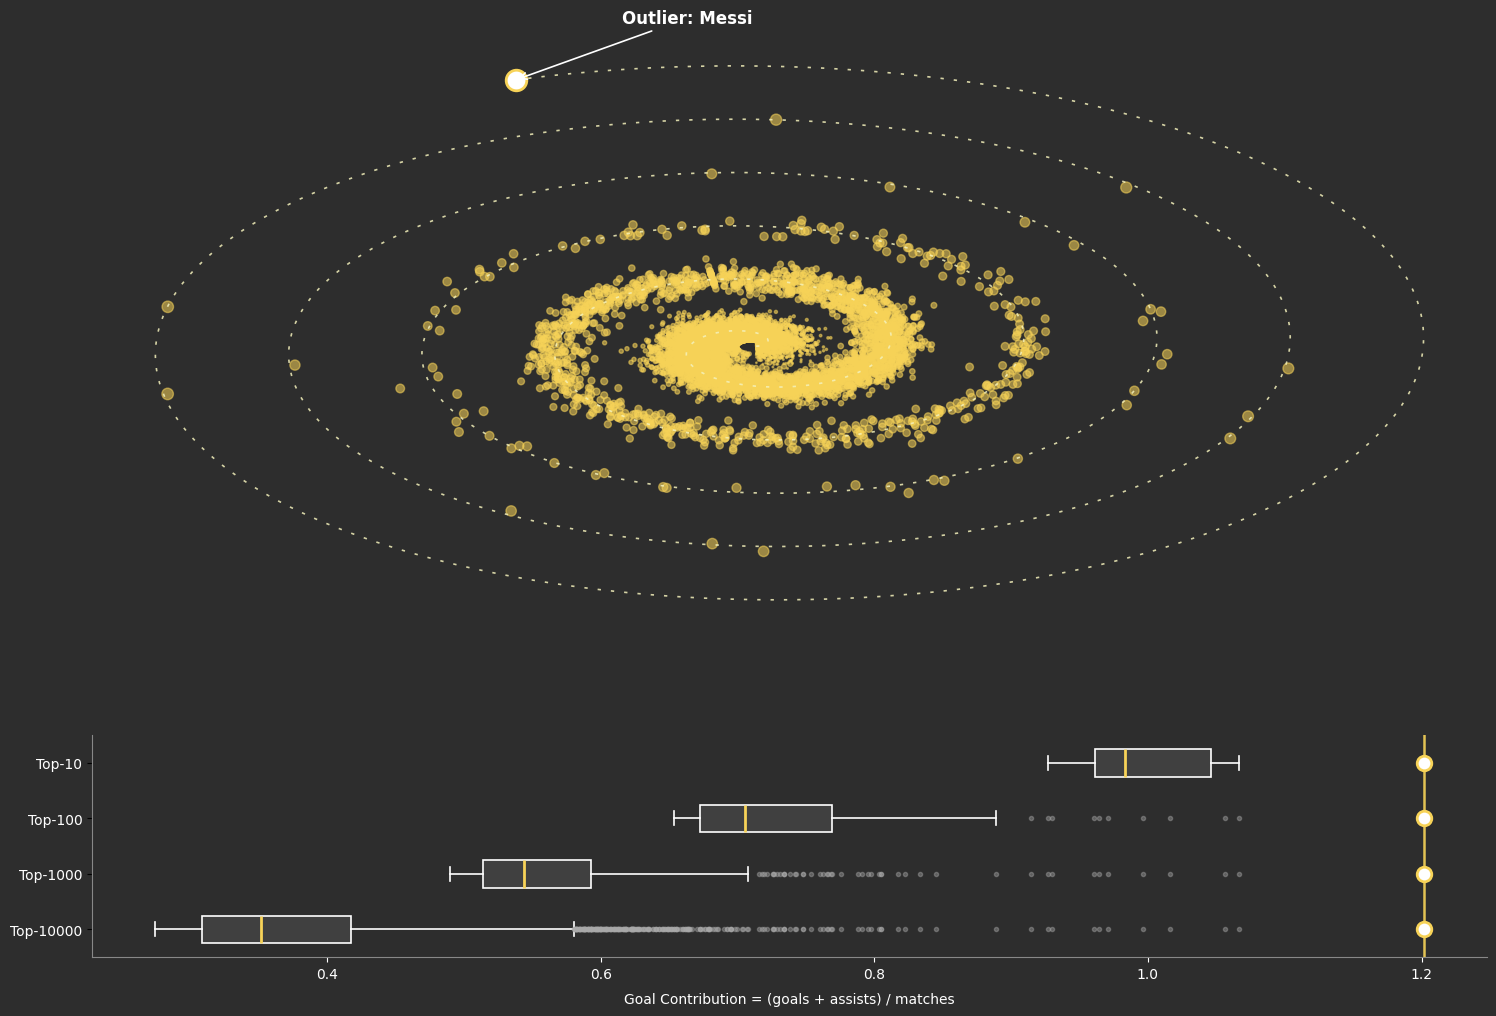

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------
# Boxplot data (build from full population, not trimmed)
# ------------------------
def build_base_population():
    df_merged = pd.read_parquet("../data/merged_player_data.parquet")
    for col in ["assists", "goals", "nb_on_pitch"]:
        df_merged[col] = pd.to_numeric(df_merged[col], errors="coerce").fillna(0)
    base = (
        df_merged.groupby("player_id", as_index=False)
        .agg({
            "player_name": "first",
            "assists": "sum",
            "goals": "sum",
            "nb_on_pitch": "sum"
        })
        .rename(columns={"nb_on_pitch": "matches"})
    )
    base = base[base["matches"] > 100].copy()
    base["GoalContribution"] = (base["goals"] + base["assists"]) / base["matches"]
    return base

df_base = build_base_population()
base_sorted = df_base.sort_values("GoalContribution", ascending=False)

def topN_vals(N):
    N = min(N, len(base_sorted))
    return base_sorted.nlargest(N, "GoalContribution")["GoalContribution"].to_numpy()

box_subsets = {
    "Top-10000": topN_vals(10000),
    "Top-1000":  topN_vals(1000),
    "Top-100":   topN_vals(100),
    "Top-10":    topN_vals(10),
}

# Messi GC from the same base
messi_row_base = base_sorted[base_sorted["player_id"] == 28003]
gc_messi_base = float(messi_row_base.iloc[0]["GoalContribution"]) if not messi_row_base.empty else base_sorted["GoalContribution"].max()

# ------------------------
# Spiral (top) using your current player_stats
# ------------------------
# --- Tunables ---
inner_pad = 0
b = 0.03
width_sigma_max = 0.03
width_sigma_min = 0.001
decay_power = 1
y_scale = 10/25

size_min = 1
size_max = 80

# --- Data prep for spiral ---
df = player_stats.copy().sort_values("GoalContribution").reset_index(drop=True)
gc = df["GoalContribution"].to_numpy()
gc_min, gc_max = gc.min(), gc.max()

messi_row = df[df["player_id"] == 28003]
gc_messi = float(messi_row.iloc[0]["GoalContribution"]) if not messi_row.empty else gc_max

a = inner_pad
r_min, r_max = a + 1e-6, 1.0
gc_norm = (gc - gc_min) / (gc_max - gc_min + 1e-12)
r = r_min + gc_norm * (r_max - r_min)
theta = (r - a) / b

# Local frames for jitter
er_x, er_y = np.cos(theta), np.sin(theta)
eθ_x, eθ_y = -np.sin(theta), np.cos(theta)
T_x = b*er_x + r*eθ_x
T_y = b*er_y + r*eθ_y
T_norm = np.hypot(T_x, T_y) + 1e-12
N_x = -T_y / T_norm
N_y =  T_x / T_norm

x0 = r * er_x
y0 = r * er_y

# Jitter taper
gc_to_messi_norm = np.clip((gc - gc_min) / (gc_messi - gc_min + 1e-12), 0, 1)
taper = (1.0 - gc_to_messi_norm) ** decay_power
sigma_i = width_sigma_min + (width_sigma_max - width_sigma_min) * taper
rng = np.random.default_rng(42)
eps = rng.normal(0, 1, size=len(theta)) * sigma_i

xj = x0 + eps * N_x
yj = y0 + eps * N_y

# Keep Messi on centerline
if not messi_row.empty:
    idx_m = int(messi_row.index[0])
    xj[idx_m], yj[idx_m] = x0[idx_m], y0[idx_m]

# Elliptical transform
X = xj
Y = yj * y_scale

# Dot sizes
sizes = size_min + (size_max - size_min) * gc_to_messi_norm

# Spiral centerline
theta_end = (r_max - a) / b
theta_grid = np.linspace(0, theta_end, 2400)
x_c = (a + b*theta_grid) * np.cos(theta_grid)
y_c = (a + b*theta_grid) * np.sin(theta_grid) * y_scale

# Messi coords
if not messi_row.empty:
    r_messi = r_min + ((gc_messi - gc_min) / (gc_max - gc_min + 1e-12)) * (r_max - r_min)
    theta_messi = (r_messi - a) / b
    Xm = r_messi * np.cos(theta_messi)
    Ym = (r_messi * np.sin(theta_messi)) * y_scale

# ------------------------
# Figure: Spiral (top) + Horizontal Boxplots (bottom)
# ------------------------
fig = plt.figure(figsize=(18, 12), facecolor="#2d2d2d")
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2.7, 1.0], hspace=0.25)

ax_sp = fig.add_subplot(gs[0, 0])
ax_box = fig.add_subplot(gs[1, 0])

# Styles
ax_sp.set_facecolor("#2d2d2d")
ax_box.set_facecolor("#2d2d2d")

# --- Top: Spiral spanning full width ---
ax_sp.plot(x_c, y_c, color="#f4f1bb", lw=1.2, ls=(0, (2, 6)), alpha=0.85, zorder=9)
ax_sp.scatter(X, Y, s=sizes, alpha=0.55, c="#f7d358", zorder=3)

if not messi_row.empty:
    ax_sp.scatter([Xm], [Ym], s=220, edgecolor="#f7d358", facecolor="white", lw=2, zorder=11)
    ax_sp.annotate("Outlier: Messi",
                   xy=(Xm, Ym), xytext=(Xm + 0.15, Ym + 0.08),
                   arrowprops=dict(arrowstyle="->", lw=1.2, color="white"),
                   fontsize=12, weight="bold", color="white", zorder=12)

# Make spiral fit nicely
ax_sp.set_aspect('equal', adjustable='box')
ax_sp.margins(0.05)
ax_sp.axis('off')

# --- Bottom: Horizontal boxplots (categories on y-axis) ---
labels = list(box_subsets.keys())
box_data = [box_subsets[k] for k in labels]
positions = np.arange(1, len(labels) + 1)

bp = ax_box.boxplot(
    box_data, vert=False, positions=positions, patch_artist=True,
    widths=0.5,
    boxprops=dict(facecolor="#404040", color="white", linewidth=1.2),
    whiskerprops=dict(color="white", linewidth=1.2),
    capprops=dict(color="white", linewidth=1.2),
    medianprops=dict(color="#f7d358", linewidth=2),
    flierprops=dict(marker='o', markerfacecolor="#aaaaaa", markeredgecolor="#aaaaaa",
                    alpha=0.4, markersize=3)
)

# Messi vertical reference line + markers on each category
ax_box.axvline(gc_messi_base, color="#f7d358", lw=1.8, alpha=0.9, zorder=4)
for y in positions:
    ax_box.scatter(gc_messi_base, y, s=110, facecolor="white", edgecolor="#f7d358", lw=2, zorder=5)

# Axis styling
ax_box.set_yticks(positions)
ax_box.set_yticklabels(labels, color="white", fontsize=10)
ax_box.set_xlabel("Goal Contribution = (goals + assists) / matches", color="white", labelpad=8)
ax_box.tick_params(axis='x', colors="white")
for spine in ["top", "right"]:
    ax_box.spines[spine].set_visible(False)
for spine in ["left", "bottom"]:
    ax_box.spines[spine].set_color("#888888")

plt.tight_layout()
plt.show()

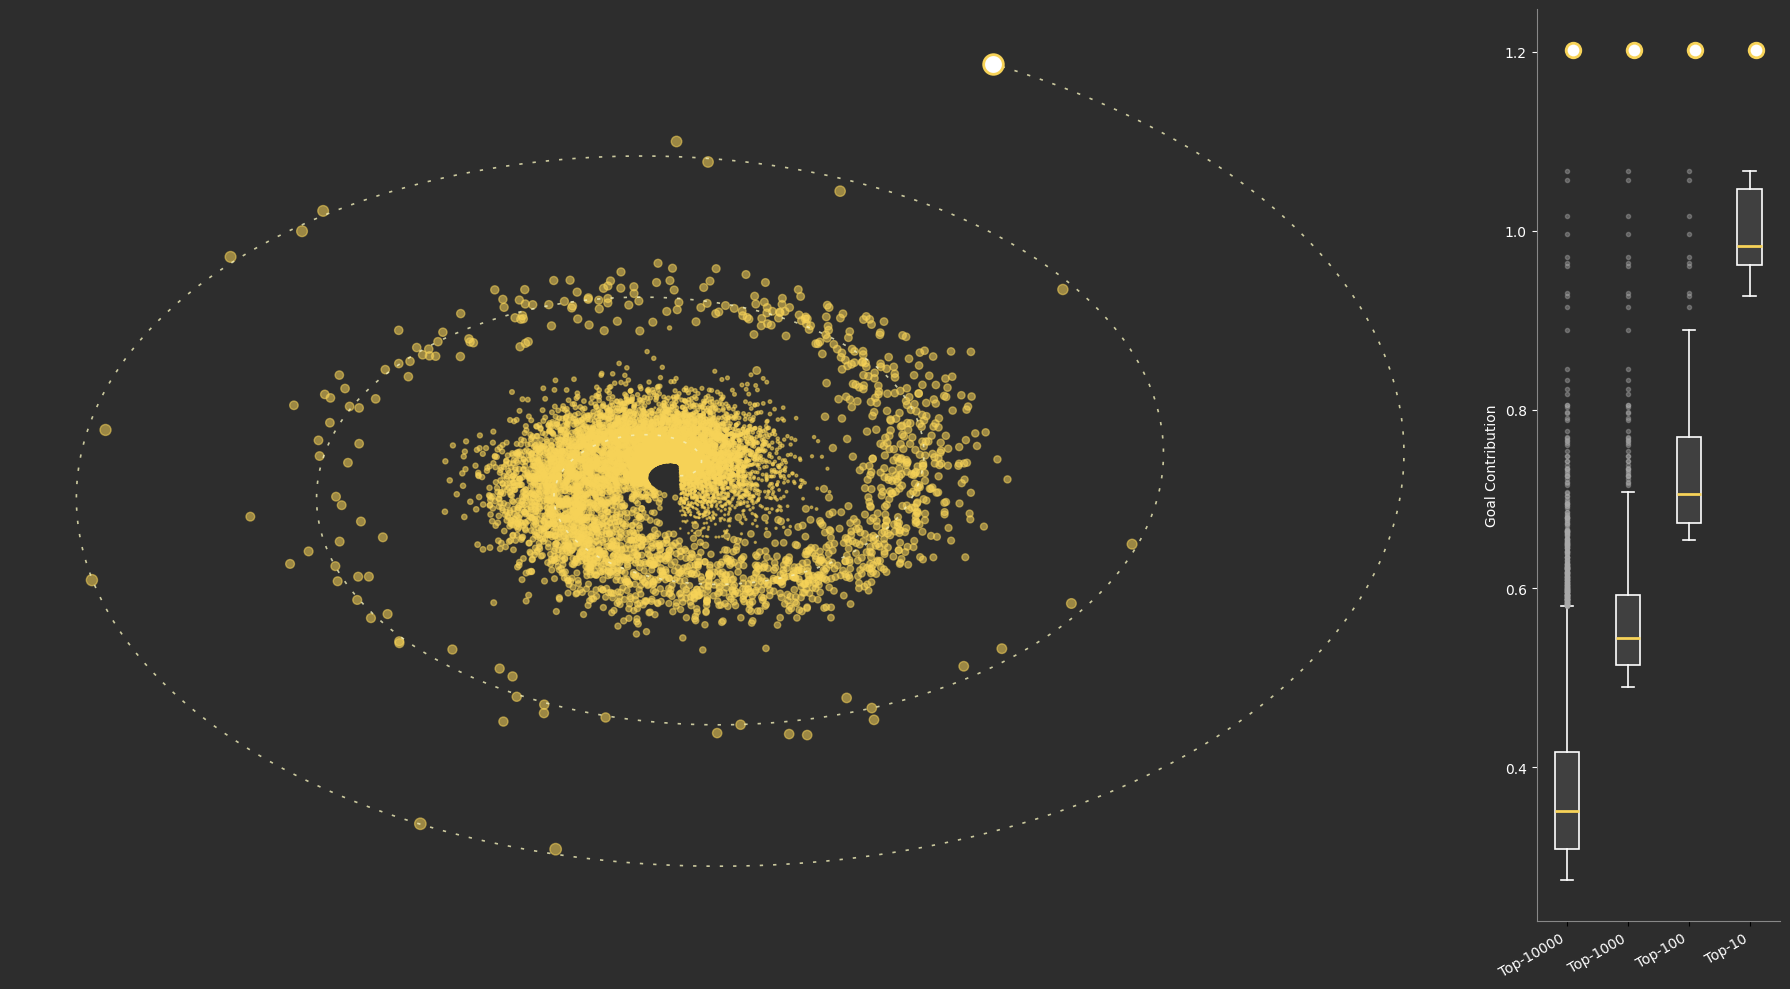

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Build base population for boxplots (correct Top-N) ---
def build_base_population():
    df_merged = pd.read_parquet("../data/merged_player_data.parquet")
    for col in ["assists", "goals", "nb_on_pitch"]:
        df_merged[col] = pd.to_numeric(df_merged[col], errors="coerce").fillna(0)
    base = (
        df_merged.groupby("player_id", as_index=False)
        .agg({
            "player_name": "first",
            "assists": "sum",
            "goals": "sum",
            "nb_on_pitch": "sum"
        })
        .rename(columns={"nb_on_pitch": "matches"})
    )
    base = base[base["matches"] > 100].copy()
    base["GoalContribution"] = (base["goals"] + base["assists"]) / base["matches"]
    return base

df_base = build_base_population()
base_sorted = df_base.sort_values("GoalContribution", ascending=False)

def topN_vals(N):
    N = min(N, len(base_sorted))
    return base_sorted.nlargest(N, "GoalContribution")["GoalContribution"].to_numpy()

box_subsets = {
    "Top-10000": topN_vals(10000),
    "Top-1000":  topN_vals(1000),
    "Top-100":   topN_vals(100),
    "Top-10":    topN_vals(10),
}

# Messi GC from the same base
messi_row_base = base_sorted[base_sorted["player_id"] == 28003]
gc_messi_base = float(messi_row_base.iloc[0]["GoalContribution"]) if not messi_row_base.empty else base_sorted["GoalContribution"].max()

# ================= Spiral panel (your code, unchanged except variables reused) =================
# --- Tunables ---
inner_pad = 0
b = 0.05
width_sigma_max = 0.06
width_sigma_min = 0.001
decay_power = 1
y_scale = 10/17

size_min = 1
size_max = 80

# --- Data prep (use your current player_stats) ---
df = player_stats.copy().sort_values("GoalContribution").reset_index(drop=True)
gc = df["GoalContribution"].to_numpy()

messi_row = df[df["player_id"] == 28003]
gc_messi = float(messi_row.iloc[0]["GoalContribution"]) if not messi_row.empty else gc.max()

# Spiral prep
gc_min, gc_max = gc.min(), gc.max()
a = inner_pad
r_min, r_max = a + 1e-6, 1.0
gc_norm = (gc - gc_min) / (gc_max - gc_min + 1e-12)
r = r_min + gc_norm * (r_max - r_min)
theta = (r - a) / b

# Local frames for jitter
er_x, er_y = np.cos(theta), np.sin(theta)
eθ_x, eθ_y = -np.sin(theta), np.cos(theta)
T_x = b*er_x + r*eθ_x
T_y = b*er_y + r*eθ_y
T_norm = np.hypot(T_x, T_y) + 1e-12
N_x = -T_y / T_norm
N_y =  T_x / T_norm

x0, y0 = r * er_x, r * er_y

# Jitter taper
gc_to_messi_norm = np.clip((gc - gc_min) / (gc_messi - gc_min + 1e-12), 0, 1)
taper = (1.0 - gc_to_messi_norm) ** decay_power
sigma_i = width_sigma_min + (width_sigma_max - width_sigma_min) * taper
rng = np.random.default_rng(42)
eps = rng.normal(0, 1, size=len(theta)) * sigma_i
xj, yj = x0 + eps * N_x, y0 + eps * N_y

if not messi_row.empty:
    idx_m = int(messi_row.index[0])
    xj[idx_m], yj[idx_m] = x0[idx_m], y0[idx_m]

# Elliptical transform
X, Y = xj, yj * y_scale

# Dot sizes
sizes = size_min + (size_max - size_min) * gc_to_messi_norm

# Spiral centerline
theta_end = (r_max - a) / b
theta_grid = np.linspace(0, theta_end, 2400)
x_c = (a + b*theta_grid) * np.cos(theta_grid)
y_c = (a + b*theta_grid) * np.sin(theta_grid) * y_scale

# Messi coords
if not messi_row.empty:
    r_messi = r_min + ((gc_messi - gc_min) / (gc_max - gc_min + 1e-12)) * (r_max - r_min)
    theta_messi = (r_messi - a) / b
    Xm, Ym = r_messi * np.cos(theta_messi), (r_messi * np.sin(theta_messi)) * y_scale

# ================= Figure (left spiral + right corrected boxplots) =================
fig, (ax_sp, ax_box) = plt.subplots(
    1, 2, figsize=(18, 10),
    gridspec_kw={'width_ratios':[3,0.5]},
    facecolor="#2d2d2d"
)
for ax in (ax_sp, ax_box):
    ax.set_facecolor("#2d2d2d")

# Spiral (left)
ax_sp.plot(x_c, y_c, color="#f4f1bb", lw=1.2, ls=(0, (2,6)), alpha=0.8, zorder=9)
ax_sp.scatter(X, Y, s=sizes, alpha=0.55, c="#f7d358", zorder=3)

if not messi_row.empty:
    ax_sp.scatter([Xm], [Ym], s=200, edgecolor="#f7d358", facecolor="white", lw=2, zorder=11)

ax_sp.set_aspect('equal', adjustable='box')
ax_sp.axis('off')

# Boxplots (right) — CORRECT top-N selections
labels = list(box_subsets.keys())
box_data = [box_subsets[k] for k in labels]

bp = ax_box.boxplot(
    box_data, vert=True, patch_artist=True, widths=0.4,
    boxprops=dict(facecolor="#404040", color="white", linewidth=1.2),
    whiskerprops=dict(color="white", linewidth=1.2),
    capprops=dict(color="white", linewidth=1.2),
    medianprops=dict(color="#f7d358", linewidth=2),
    flierprops=dict(marker='o', markerfacecolor="#aaaaaa", markeredgecolor="#aaaaaa", alpha=0.4, markersize=3)
)

# Messi overlay from the same base
for i in range(1, len(labels)+1):
    ax_box.scatter(i + 0.10, gc_messi_base, s=110, facecolor="white",
                   edgecolor="#f7d358", lw=2, zorder=5)

ax_box.set_ylabel("Goal Contribution", color="white")
ax_box.set_xticks(range(1, len(labels)+1))
ax_box.set_xticklabels(labels, color="white", rotation=30, ha="right", fontsize=10)
ax_box.tick_params(axis='y', colors="white")
for spine in ["top","right"]:
    ax_box.spines[spine].set_visible(False)
for spine in ["left","bottom"]:
    ax_box.spines[spine].set_color("#888888")

plt.tight_layout()
plt.show()


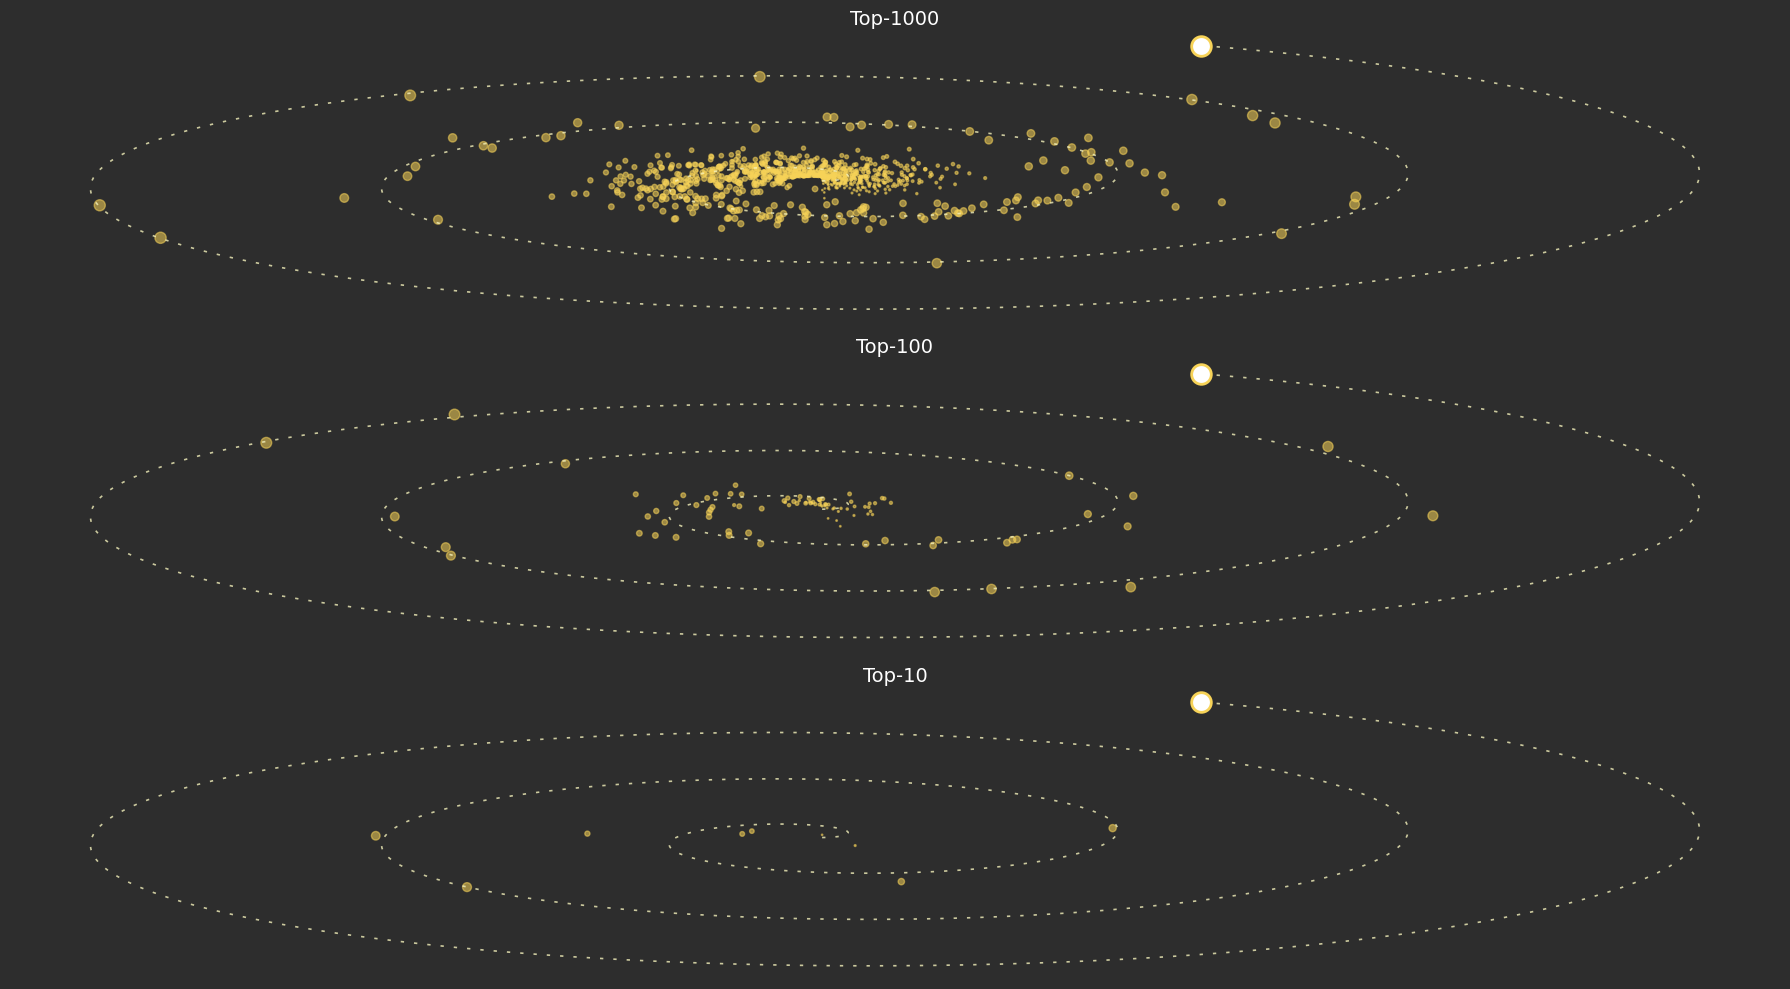

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Build base population ---
def build_base_population():
    df_merged = pd.read_parquet("../data/merged_player_data.parquet")
    for col in ["assists", "goals", "nb_on_pitch"]:
        df_merged[col] = pd.to_numeric(df_merged[col], errors="coerce").fillna(0)
    base = (
        df_merged.groupby("player_id", as_index=False)
        .agg({
            "player_name": "first",
            "assists": "sum",
            "goals": "sum",
            "nb_on_pitch": "sum"
        })
        .rename(columns={"nb_on_pitch": "matches"})
    )
    base = base[base["matches"] > 100].copy()
    base["GoalContribution"] = (base["goals"] + base["assists"]) / base["matches"]
    return base

df_base = build_base_population()
base_sorted = df_base.sort_values("GoalContribution", ascending=False)

def build_spiral_data(sub_df, y_scale=10/17, b=0.05,
                      width_sigma_max=0.06, width_sigma_min=0.001,
                      decay_power=1, size_min=1, size_max=80):
    """Return spiral plot data for a subset of players."""
    df = sub_df.sort_values("GoalContribution").reset_index(drop=True)
    gc = df["GoalContribution"].to_numpy()
    gc_min, gc_max = gc.min(), gc.max()

    messi_row = df[df["player_id"] == 28003]
    gc_messi = float(messi_row.iloc[0]["GoalContribution"]) if not messi_row.empty else gc.max()

    # Spiral prep
    a = 0
    r_min, r_max = a + 1e-6, 1.0
    gc_norm = (gc - gc_min) / (gc_max - gc_min + 1e-12)
    r = r_min + gc_norm * (r_max - r_min)
    theta = (r - a) / b

    # Local frames for jitter
    er_x, er_y = np.cos(theta), np.sin(theta)
    eθ_x, eθ_y = -np.sin(theta), np.cos(theta)
    T_x = b*er_x + r*eθ_x
    T_y = b*er_y + r*eθ_y
    T_norm = np.hypot(T_x, T_y) + 1e-12
    N_x = -T_y / T_norm
    N_y =  T_x / T_norm

    x0, y0 = r * er_x, r * er_y

    # Jitter taper
    gc_to_messi_norm = np.clip((gc - gc_min) / (gc_messi - gc_min + 1e-12), 0, 1)
    taper = (1.0 - gc_to_messi_norm) ** decay_power
    sigma_i = width_sigma_min + (width_sigma_max - width_sigma_min) * taper
    rng = np.random.default_rng(42)
    eps = rng.normal(0, 1, size=len(theta)) * sigma_i
    xj, yj = x0 + eps * N_x, y0 + eps * N_y

    if not messi_row.empty:
        idx_m = int(messi_row.index[0])
        xj[idx_m], yj[idx_m] = x0[idx_m], y0[idx_m]

    # Elliptical transform
    X, Y = xj, yj * y_scale

    # Dot sizes
    sizes = size_min + (size_max - size_min) * gc_to_messi_norm

    # Spiral centerline
    theta_end = (r_max - a) / b
    theta_grid = np.linspace(0, theta_end, 2400)
    x_c = (a + b*theta_grid) * np.cos(theta_grid)
    y_c = (a + b*theta_grid) * np.sin(theta_grid) * y_scale

    # Messi coords
    Xm, Ym = None, None
    if not messi_row.empty:
        r_messi = r_min + ((gc_messi - gc_min) / (gc_max - gc_min + 1e-12)) * (r_max - r_min)
        theta_messi = (r_messi - a) / b
        Xm, Ym = r_messi * np.cos(theta_messi), (r_messi * np.sin(theta_messi)) * y_scale

    return X, Y, sizes, x_c, y_c, Xm, Ym

# --- Build subsets ---
subsets = {
    "Top-1000": base_sorted.head(1000),
    "Top-100": base_sorted.head(100),
    "Top-10": base_sorted.head(10)
}

# --- Figure with 3 stacked spirals, keep overall 18:10 ---
fig, axes = plt.subplots(
    3, 1,
    figsize=(18, 10),
    gridspec_kw={'height_ratios':[1,1,1]},  # equal share but can be tuned
    facecolor="#2d2d2d"
)

for ax, (label, subdf) in zip(axes, subsets.items()):
    ax.set_facecolor("#2d2d2d")

    X, Y, sizes, x_c, y_c, Xm, Ym = build_spiral_data(subdf)

    # Spiral centerline
    ax.plot(x_c, y_c, color="#f4f1bb", lw=1.2, ls=(0, (2,6)), alpha=0.8, zorder=9)
    ax.scatter(X, Y, s=sizes, alpha=0.55, c="#f7d358", zorder=3)

    # Messi highlight
    if Xm is not None:
        ax.scatter([Xm], [Ym], s=200, edgecolor="#f7d358",
                   facecolor="white", lw=2, zorder=11)

    ax.set_aspect('auto')
    ax.axis('off')
    ax.set_title(label, color="white", fontsize=14, pad=6)

plt.tight_layout()
plt.show()

/var/folders/b8/g8r4mzvj7pg79w2br6cpzy8c0000gn/T/ipykernel_37950/1079372316.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


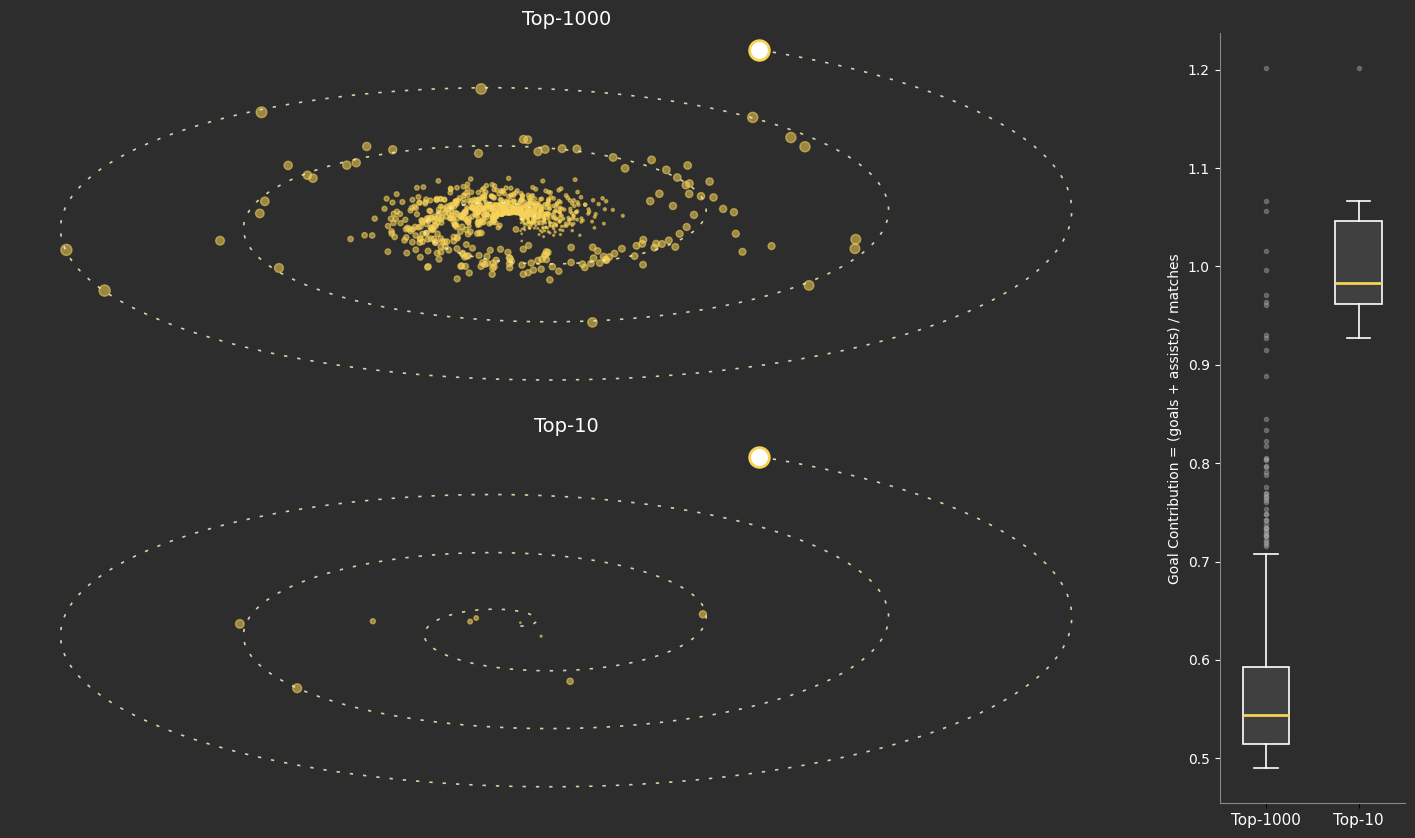

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Build base population ---
def build_base_population():
    df_merged = pd.read_parquet("../data/merged_player_data.parquet")
    for col in ["assists", "goals", "nb_on_pitch"]:
        df_merged[col] = pd.to_numeric(df_merged[col], errors="coerce").fillna(0)
    base = (
        df_merged.groupby("player_id", as_index=False)
        .agg({
            "player_name": "first",
            "assists": "sum",
            "goals": "sum",
            "nb_on_pitch": "sum"
        })
        .rename(columns={"nb_on_pitch": "matches"})
    )
    base = base[base["matches"] > 100].copy()
    base["GoalContribution"] = (base["goals"] + base["assists"]) / base["matches"]
    return base

df_base = build_base_population()
base_sorted = df_base.sort_values("GoalContribution", ascending=False)

def build_spiral_data(sub_df, y_scale=10/17, b=0.05,
                      width_sigma_max=0.06, width_sigma_min=0.001,
                      decay_power=1, size_min=1, size_max=80):
    """Return spiral plot data for a subset of players."""
    df = sub_df.sort_values("GoalContribution").reset_index(drop=True)
    gc = df["GoalContribution"].to_numpy()
    gc_min, gc_max = gc.min(), gc.max()

    messi_row = df[df["player_id"] == 28003]
    gc_messi = float(messi_row.iloc[0]["GoalContribution"]) if not messi_row.empty else gc.max()

    # Spiral prep
    a = 0
    r_min, r_max = a + 1e-6, 1.0
    gc_norm = (gc - gc_min) / (gc_max - gc_min + 1e-12)
    r = r_min + gc_norm * (r_max - r_min)
    theta = (r - a) / b

    # Local frames for jitter
    er_x, er_y = np.cos(theta), np.sin(theta)
    eθ_x, eθ_y = -np.sin(theta), np.cos(theta)
    T_x = b*er_x + r*eθ_x
    T_y = b*er_y + r*eθ_y
    T_norm = np.hypot(T_x, T_y) + 1e-12
    N_x, N_y = -T_y / T_norm, T_x / T_norm

    x0, y0 = r * er_x, r * er_y

    # Jitter taper
    gc_to_messi_norm = np.clip((gc - gc_min) / (gc_messi - gc_min + 1e-12), 0, 1)
    taper = (1.0 - gc_to_messi_norm) ** decay_power
    sigma_i = width_sigma_min + (width_sigma_max - width_sigma_min) * taper
    rng = np.random.default_rng(42)
    eps = rng.normal(0, 1, size=len(theta)) * sigma_i
    xj, yj = x0 + eps * N_x, y0 + eps * N_y

    # Keep Messi on centerline
    if not messi_row.empty:
        idx_m = int(messi_row.index[0])
        xj[idx_m], yj[idx_m] = x0[idx_m], y0[idx_m]

    # Elliptical transform
    X, Y = xj, yj * y_scale

    # Dot sizes
    sizes = size_min + (size_max - size_min) * gc_to_messi_norm

    # Spiral centerline
    theta_end = (r_max - a) / b
    theta_grid = np.linspace(0, theta_end, 2400)
    x_c = (a + b*theta_grid) * np.cos(theta_grid)
    y_c = (a + b*theta_grid) * np.sin(theta_grid) * y_scale

    # Messi coords
    Xm, Ym = None, None
    if not messi_row.empty:
        r_messi = r_min + ((gc_messi - gc_min) / (gc_max - gc_min + 1e-12)) * (r_max - r_min)
        theta_messi = (r_messi - a) / b
        Xm, Ym = r_messi * np.cos(theta_messi), (r_messi * np.sin(theta_messi)) * y_scale

    return X, Y, sizes, x_c, y_c, Xm, Ym

# --- Subsets ---
spiral_subsets = {
    "Top-1000": base_sorted.head(1000),
    "Top-10":   base_sorted.head(10)
}

# Boxplot data (GoalContribution on Y axis)
box_labels = ["Top-1000", "Top-10"]
box_vals = [base_sorted.head(1000)["GoalContribution"].to_numpy(),
            base_sorted.head(10)["GoalContribution"].to_numpy()]

# --- Figure: 2x2 grid, right col spans both rows for boxplots ---
fig = plt.figure(figsize=(18, 10), facecolor="#2d2d2d")
gs = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[3, 0.5], height_ratios=[1, 1], wspace=0.15, hspace=0.12)

ax_sp_top = fig.add_subplot(gs[0, 0])
ax_sp_mid = fig.add_subplot(gs[1, 0])
ax_box = fig.add_subplot(gs[:, 1])  # spans both rows

for ax in (ax_sp_top, ax_sp_mid, ax_box):
    ax.set_facecolor("#2d2d2d")

# --- Spirals (left column) ---
for ax, (label, subdf) in zip([ax_sp_top, ax_sp_mid], spiral_subsets.items()):
    X, Y, sizes, x_c, y_c, Xm, Ym = build_spiral_data(subdf)
    ax.plot(x_c, y_c, color="#f4f1bb", lw=1.2, ls=(0, (2,6)), alpha=0.85, zorder=9)
    ax.scatter(X, Y, s=sizes, alpha=0.55, c="#f7d358", zorder=3)
    if Xm is not None:
        ax.scatter([Xm], [Ym], s=200, edgecolor="#f7d358", facecolor="white", lw=2, zorder=11)
    ax.set_aspect('auto')        # fills panel; set 'equal' if you prefer perfect shape
    ax.axis('off')
    ax.set_title(label, color="white", fontsize=14, pad=6)

# --- Boxplots (right column), GoalContribution on Y axis ---
bp = ax_box.boxplot(
    box_vals,
    vert=True,                 # y-axis = GoalContribution
    patch_artist=True,
    widths=0.5,
    positions=[1, 2],
    boxprops=dict(facecolor="#404040", color="white", linewidth=1.2),
    whiskerprops=dict(color="white", linewidth=1.2),
    capprops=dict(color="white", linewidth=1.2),
    medianprops=dict(color="#f7d358", linewidth=2),
    flierprops=dict(marker='o', markerfacecolor="#aaaaaa", markeredgecolor="#aaaaaa",
                    alpha=0.4, markersize=3)
)

ax_box.set_xticks([1, 2])
ax_box.set_xticklabels(box_labels, color="white", fontsize=11)
ax_box.set_ylabel("Goal Contribution = (goals + assists) / matches", color="white")
ax_box.tick_params(axis='y', colors="white")

# Styling
for spine in ["top", "right"]:
    ax_box.spines[spine].set_visible(False)
for spine in ["left", "bottom"]:
    ax_box.spines[spine].set_color("#888888")

plt.tight_layout()
plt.show()